In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 1. $Q_0 = 0$, and $Q_{target} = 100$

#### 1) Load and Clean Data

In [49]:
df = pd.read_csv("crsp_nflx.csv", parse_dates=["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.dropna(subset=["PRC"])

In [50]:
T_total = len(df) - 1  # number of trading periods
T = T_total  # index periods 0,...,T

#### 2) Construct Synthetic Alpha Signal

In [51]:
# alpha_t = (price[t+1] - price[t]) / price[t], then smooth
df["raw_alpha"] = (df["PRC"].shift(-1) / df["PRC"] - 1)
df["alpha"] = df["raw_alpha"].rolling(window=5, min_periods=1).mean()

# for t = T, fill with last valid value
df["alpha"].ffill(inplace=True)
alpha = df["alpha"].values[:T+1]  # alpha_0,...,alpha_T

delta_alpha = np.diff(alpha)

#### 3) Set Parameters and Define $\gamma_t$ and $\lambda_t$

In [52]:
# use a constant impact decay tau and a linear gamma_t

tau = 5.0  # constant impact decay timescale
w = 0.05   # linear impact cost parameter (h(J)=wJ)
penalty = 0.01  # penalty weight on position deviation
Q_target = 100.0  # target final portfolio position
Q0 = 0.0         # initial position
J0 = 0.0         # initial impact state

# choose gamma_t as a smooth linear function over time: gamma_t = gamma0 + (gammaT - gamma0)*(t/T)
gamma0 = 0.0
gammaT = 0.1 
gamma = np.linspace(gamma0, gammaT, T+1)
lambda_vals = np.exp(gamma)  # lambda_t = exp(gamma_t)

delta_gamma = np.diff(gamma)

#### 4) Set Up the Optimization Problem in CVXPY

In [53]:
# decision variable: J \in R^(T+1), where J[0] = J0 is fixed.
J = cp.Variable(T+1)

objective_terms = []

In [54]:
# sum from k=0 to T-1
for k in range(T):
    term_k = (np.exp(-gamma[k]) *
              ( J[k] * delta_alpha[k] 
                + (1/tau + delta_gamma[k]) * alpha[k] * J[k]
                - (1/tau) * (w * cp.square(J[k])) 
                - delta_gamma[k] * (0.5 * w * cp.square(J[k]) )
              )
             )
    objective_terms.append(term_k)

In [55]:
# terminal term at k=T:
terminal_term = np.exp(-gamma[T]) * (alpha[T] * J[T] - 0.5 * w * cp.square(J[T]))
objective_terms.append(terminal_term)

In [56]:
# deviation term:

position_increment = []
for i in range(T):
    position_increment.append((J[i+1] - (1 - 1/tau)*J[i]) / lambda_vals[i])
Q_T_expr = Q0 + cp.sum(cp.hstack(position_increment))
deviation = Q_target - Q_T_expr
penalty_term = - penalty * cp.square(deviation)

In [57]:
# full objective:
objective = cp.Maximize(cp.sum(cp.hstack(objective_terms)) + penalty_term)

constraints = [J[0] == J0]

# formulate problem
prob = cp.Problem(objective, constraints)

#### 5) Solve the Optimization Problem

In [58]:
try:
    prob.solve(solver=cp.SCS, verbose=True)
except Exception as e:
    print("Solver failed:", e)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Feb 27 01:49:21 PM: Your problem has 1510 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 27 01:49:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 27 01:49:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 27 01:49:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 27 01:49:22 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 27 01:49:22 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Con

In [59]:
print("Optimal value:", prob.value)
J_opt = J.value  # optimal J_t sequence

Optimal value: 0.3653876585774701


In [60]:
J_opt

array([-4.16520371e-10,  9.58176610e-01,  3.84803268e-01, ...,
        1.85378141e-01, -5.05016347e-02,  4.39586148e-01])

#### 6) Recover the Portfolio Position Q_t

In [61]:
Q_history = [Q0]
for i in range(T):
    delta_Q_i = (J_opt[i+1] - (1 - 1/tau)*J_opt[i]) / lambda_vals[i]
    Q_history.append(Q_history[-1] + delta_Q_i)
Q_history = np.array(Q_history)

#### 7) Plot the Optimal Impact State and Portfolio Trajectory

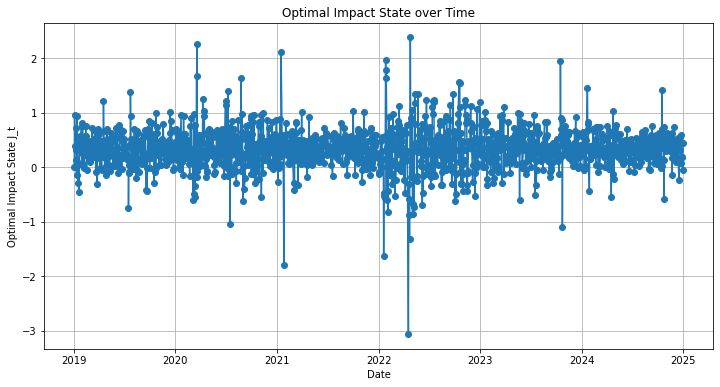

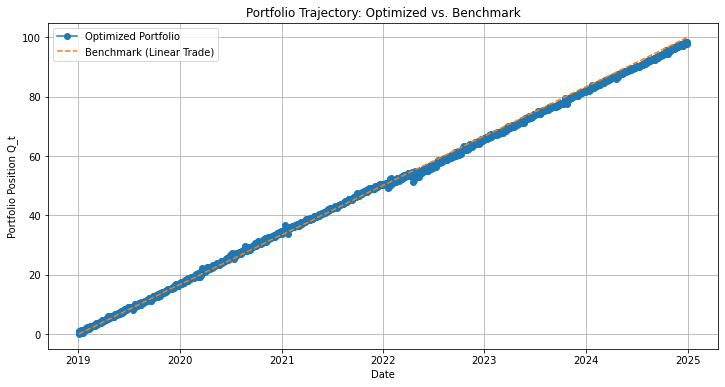

Final portfolio position: 98.35 (Target: 100.0)
Deviation from target: 1.65


In [63]:
dates = df["date"].values[:T+1]

plt.figure(figsize=(12,6))
plt.plot(dates, J_opt, marker='o')
plt.xlabel("Date")
plt.ylabel("Optimal Impact State J_t")
plt.title("Optimal Impact State over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(dates, Q_history, marker='o', label="Optimized Portfolio")

# sample benchmark: linear interpolation from Q0 to Q_target
benchmark = np.linspace(Q0, Q_target, T+1)
plt.plot(dates, benchmark, linestyle="--", label="Benchmark (Linear Trade)")
plt.xlabel("Date")
plt.ylabel("Portfolio Position Q_t")
plt.title("Portfolio Trajectory: Optimized vs. Benchmark")
plt.legend()
plt.grid(True)
plt.show()

# final metrics
final_Q = Q_history[-1]
print(f"Final portfolio position: {final_Q:.2f} (Target: {Q_target})")
print(f"Deviation from target: {abs(final_Q - Q_target):.2f}")

## 2. $Q_0 = Q_{target} = 100$

#### 1) Load and Clean Data

In [64]:
df = pd.read_csv("crsp_nflx.csv", parse_dates=["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.dropna(subset=["PRC"])

In [65]:
T_total = len(df) - 1  # number of trading periods
T = T_total  # index periods 0,...,T

#### 2) Construct Synthetic Alpha Signal

In [66]:
# alpha_t = (price[t+1] - price[t]) / price[t], then smooth
df["raw_alpha"] = (df["PRC"].shift(-1) / df["PRC"] - 1)
df["alpha"] = df["raw_alpha"].rolling(window=5, min_periods=1).mean()

# for t = T, fill with last valid value
df["alpha"].ffill(inplace=True)
alpha = df["alpha"].values[:T+1]  # alpha_0,...,alpha_T

delta_alpha = np.diff(alpha)

#### 3) Set Parameters and Define $\gamma_t$ and $\lambda_t$

In [67]:
# use a constant impact decay tau and a linear gamma_t

tau = 5.0  # constant impact decay timescale
w = 0.05   # linear impact cost parameter (h(J)=wJ)
penalty = 0.01  # penalty weight on position deviation
Q_target = 100.0  # target final portfolio position
Q0 = 100.0         # initial position
J0 = 0.0         # initial impact state

# choose gamma_t as a smooth linear function over time: gamma_t = gamma0 + (gammaT - gamma0)*(t/T)
gamma0 = 0.0
gammaT = 0.1 
gamma = np.linspace(gamma0, gammaT, T+1)
lambda_vals = np.exp(gamma)  # lambda_t = exp(gamma_t)

delta_gamma = np.diff(gamma)

#### 4) Set Up the Optimization Problem in CVXPY

In [68]:
# decision variable: J \in R^(T+1), where J[0] = J0 is fixed.
J = cp.Variable(T+1)

objective_terms = []

In [69]:
# sum from k=0 to T-1
for k in range(T):
    term_k = (np.exp(-gamma[k]) *
              ( J[k] * delta_alpha[k] 
                + (1/tau + delta_gamma[k]) * alpha[k] * J[k]
                - (1/tau) * (w * cp.square(J[k])) 
                - delta_gamma[k] * (0.5 * w * cp.square(J[k]) )
              )
             )
    objective_terms.append(term_k)

In [70]:
# terminal term at k=T:
terminal_term = np.exp(-gamma[T]) * (alpha[T] * J[T] - 0.5 * w * cp.square(J[T]))
objective_terms.append(terminal_term)

In [71]:
# deviation term:

position_increment = []
for i in range(T):
    position_increment.append((J[i+1] - (1 - 1/tau)*J[i]) / lambda_vals[i])
Q_T_expr = Q0 + cp.sum(cp.hstack(position_increment))
deviation = Q_target - Q_T_expr
penalty_term = - penalty * cp.square(deviation)

In [72]:
# full objective:
objective = cp.Maximize(cp.sum(cp.hstack(objective_terms)) + penalty_term)

constraints = [J[0] == J0]

# formulate problem
prob = cp.Problem(objective, constraints)

#### 5) Solve the Optimization Problem

In [73]:
try:
    prob.solve(solver=cp.SCS, verbose=True)
except Exception as e:
    print("Solver failed:", e)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Feb 27 01:50:02 PM: Your problem has 1510 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 27 01:50:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 27 01:50:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 27 01:50:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 27 01:50:03 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 27 01:50:03 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Con

In [74]:
print("Optimal value:", prob.value)
J_opt = J.value  # optimal J_t sequence

Optimal value: 1.9740942003206714


In [75]:
J_opt

array([-9.47960311e-10,  6.17941132e-01,  4.45677893e-02, ...,
       -1.54857337e-01, -3.90737114e-01, -2.40817191e-01])

#### 6) Recover the Portfolio Position Q_t

In [76]:
Q_history = [Q0]
for i in range(T):
    delta_Q_i = (J_opt[i+1] - (1 - 1/tau)*J_opt[i]) / lambda_vals[i]
    Q_history.append(Q_history[-1] + delta_Q_i)
Q_history = np.array(Q_history)

#### 7) Plot the Optimal Impact State and Portfolio Trajectory

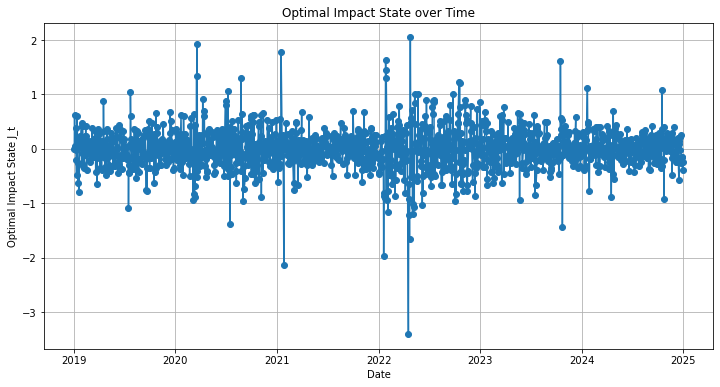

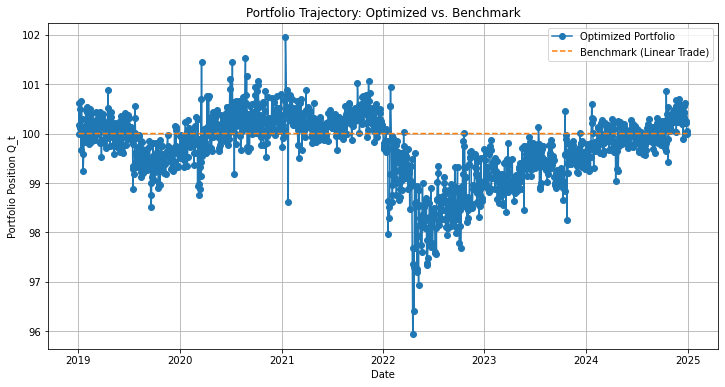

Final portfolio position: 100.05 (Target: 100.0)
Deviation from target: 0.05


In [77]:
dates = df["date"].values[:T+1]

plt.figure(figsize=(12,6))
plt.plot(dates, J_opt, marker='o')
plt.xlabel("Date")
plt.ylabel("Optimal Impact State J_t")
plt.title("Optimal Impact State over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(dates, Q_history, marker='o', label="Optimized Portfolio")

# sample benchmark: linear interpolation from Q0 to Q_target
benchmark = np.linspace(Q0, Q_target, T+1)
plt.plot(dates, benchmark, linestyle="--", label="Benchmark (Linear Trade)")
plt.xlabel("Date")
plt.ylabel("Portfolio Position Q_t")
plt.title("Portfolio Trajectory: Optimized vs. Benchmark")
plt.legend()
plt.grid(True)
plt.show()

# final metrics
final_Q = Q_history[-1]
print(f"Final portfolio position: {final_Q:.2f} (Target: {Q_target})")
print(f"Deviation from target: {abs(final_Q - Q_target):.2f}")